In [1]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr
from eofs.standard import Eof

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import matplotlib.path as mpath

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

In [3]:
from datetime import datetime 
from datetime import timedelta
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [4]:
##pip install tensorflow

In [5]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

2022-08-29 13:17:52.382865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 13:17:52.382929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
root_data='/s2s/mpyrina/Lorentz_Workshop/Data/'
root_results='/s2s/mpyrina/Lorentz_Workshop/Results/'

In [7]:
pwd

'/home/mpyrina/Notebooks/Lorentz_workshop'

In [8]:
exec(open('/home/mpyrina/Notebooks/Lorentz_workshop/L_functions.py').read())

# Data
## Target data: index time series contaning only OND values

Frozen({'latitude': 28, 'longitude': 31})
value of the 33 percentile 0.00027705061818355853
tp index <xarray.Dataset>
Dimensions:   (time: 3772)
Coordinates:
  * time      (time) datetime64[ns] 1980-10-01 1980-10-02 ... 2020-12-31
    quantile  float64 0.33
Data variables:
    tp        (time) int64 dask.array<chunksize=(3772,), meta=np.ndarray>


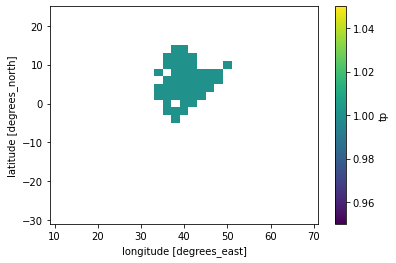

In [9]:
# Import regional mask
file = 'era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(root_data+file,
                       combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values=1 and mask the rest with nan
mask_nan.tp.plot()
print(mask_nan.sizes)

# Calculate the spatial mean of the tp file after applying the spatial mask
file=xr.open_mfdataset(root_data+'era5_tp_1959-2021_1_12_daily_2.0deg.nc',
                        combine='by_coords',parallel=True)
tp_dim=file.sel(longitude=slice(10,70),latitude=slice(24,-30))
tp_series=np.multiply(mask_nan,tp_dim).mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# Calculate 33 percentile
# Create daily values equal to a 31 day rolling. Select OND 2000-2020 data to decide the quantile threshold
tp_rol_q=tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.year.isin([np.arange(2000,2021)]))
tp_quantile=tp_rol_q.sel(time=tp_rol_q.time.dt.month.isin([10,11,12])).quantile(0.33)
print('value of the 33 percentile',tp_quantile.tp.values)

# Create index time series
# Replace the values bellow the 33 percentile with 1 and the rest with zeros
tp_rol = tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_rol_sel = tp_rol.sel(time = slice('1980','2020'))
tp_index = tp_rol_sel < tp_quantile
tp_index = tp_index.astype(int)
print('tp index',tp_index)

number of 0 and 1:  (array([0, 1]), array([1937,  605]))
<bound method Mapping.values of <xarray.Dataset>
Dimensions:   (time: 2542)
Coordinates:
  * time      (time) datetime64[ns] 1980-10-16 1980-10-17 ... 2020-12-16
    quantile  float64 0.33
Data variables:
    tp        (time) int64 dask.array<chunksize=(62,), meta=np.ndarray>>


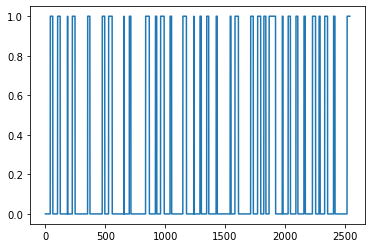

In [10]:
# Select from the index time series the period for the target values (predictant) 
# Oct 16 to Dec 16 for the period 1980-2020 (each day corresponds to a 31-day rolling mean)

target_time_series=tp_index

for iyr in range(1980,2021): # do not use the year 2021, in order to keep it for the final prediction skill scores
    if iyr == 1980:
        tp_target = target_time_series.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))
    else:
        tp_target = xr.concat([tp_target,target_time_series.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))], dim='time')
print('number of 0 and 1: ',np.unique(tp_target['tp'],return_counts=True))

print(tp_target.values)
plt.plot(tp_target.tp)

# Make it into a numpy array
y_target=tp_target.tp.to_numpy()

## Predictor data

In [14]:
exec(open('/home/mpyrina/Notebooks/Lorentz_workshop/L_functions.py').read())

In [ ]:
# Predictor data preprocessing

file_vars= ['ERA5_t2m', 'era5_t_850hpa', 'era5_z_200hpa', 'era5_z_500hpa', 'sst', 'era5_olr']
header_vars=['t2m', 't', 'z', 'z', 'sst', 'olr-mean']

lon_slices=['-15,55','-30,90','-30,90','-30,90','40,180','-180,180']
lat_slices=['15,0','30,-20','30,-20','30,-20','20,-10','20,-20']

start_year=1980
end_year=2020
rm_predictor=7

for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):
    
    if file_var=='era5_olr':
        file = xr.open_mfdataset(root_data+file_var+'_1950_2021_daily_1deg_tropics.nc',
                                 combine='by_coords',parallel=True)
        print('olr')
        var_dim = file.sel(lon=slice(lon_slice),lat=slice(lat_slice))
        lon = var_dim.coords['lon'].values
        lat = var_dim.coords['lat'].values
    else:
        file = xr.open_mfdataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc',
                                 combine='by_coords',parallel=True)
        print('other var')
        var_dim = file.sel(longitude=slice(lon_slice),latitude=slice(lat_slice))
        lon = var_dim.coords['longitude'].values
        lat = var_dim.coords['latitude'].values

    nlon = len(lon)
    nlat = len(lat)

    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(start_year,end_year+1)])).rolling(time=rm_predictor, center=False).mean(skipna=True) #.dropna(dim='time')
    #print('variable dimentions',var_series.sizes)
    
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    
    # Apply EOF -- focus on July to Sep
    var_anom_sel = var_anom_series.sel(time=var_anom_series.time.dt.month.isin([7,8,9,10,11]))[header_var].values
    # first, make a grid out of the longitude and latitude vectors so they have the same dimensions 
    lon2d,lat2d = np.meshgrid(lon,lat)
    wgts = np.cos(lat2d/180*np.pi)**0.5 #create weighting for the spatial mean
    print(wgts.shape)
    solver = Eof(var_anom_sel,weights=wgts)
    
    # EOFs are multiplied by the square-root of their eigenvalues (then the EOF patterns will carry the units)
    nmode = 5
    EOF = solver.eofs(neofs=nmode,eofscaling=2) # get the first four eofs
    print('EOF shape',np.shape(EOF))
    eigenv = solver.eigenvalues(neigs=nmode)
    print('eigenvalues',eigenv)
    VarEx = solver.varianceFraction(neigs=nmode)*100
    print('explained variance',sum(VarEx))
    PC = solver.pcs(npcs=nmode,pcscaling=1) #PCs are scaled to unit variance (divided by the square-root of their eigenvalue)
    print('PC shape',np.shape(PC))
    
    mode = np.arange(nmode)
    var_anom_dim = var_anom_series.sel(time=var_anom_series.time.dt.month.isin([7,8,9,10,11]))
    time_dim = var_anom_dim.coords['time']
    print(var_anom_dim.coords['time'])
    pc_xr = xr.DataArray(PC, coords={'time': time_dim, 'mode': mode}, dims=["time","mode"])
    
    np.save(root_results+'PC_series_n_'+str(nmode)+'_var_'+file_var+'_.npy',PC)
    pc_xr.to_netcdf(root_results+'PC_series_n_'+str(nmode)+'_var_'+file_var+'_.nc')

In [39]:
len(tp_target['tp'])

2542

In [72]:
SYY = 1980
EYY = 2021
SMM = 10
SDD = 16
EMM = 12
EDD = 16

ntimestep = 60
rw = 31 # running mean window for target
half_rw = int(rw/2)

lead_time = 14
rw_1 = 7 # running mean window for predictor

#Import predictors
nmode=5
var_num=6
pc_xr = xr.open_mfdataset(root_results+'PC_serie*.nc',concat_dim="mode",combine="nested")# Frozen({'time': 6273, 'mode': 30})

# 31-day running mean so 15 days before the central day + 2 weeks in advance + 7-day running mean + 30-day time steps
date_target = datetime.strftime(datetime(year=SYY,month=SMM,day=SDD), "%Y.%m.%d")
pc_predictor = np.ndarray((len(tp_target['tp']),ntimestep,nmode*var_num))
it = 0
ii = 0
YYY = SYY
while YYY < EYY:
    date_start = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")-timedelta(days=half_rw+lead_time+rw_1+ntimestep-1),"%Y.%m.%d")
    date_end = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")-timedelta(days=half_rw+lead_time+rw_1),"%Y.%m.%d")
    print(date_target,date_start,date_end,it)
    pc_predictor[ii,:,:] = pc_xr.sel(time = slice(date_start,date_end)).values
    if date_target == datetime.strftime(datetime(year=YYY,month=EMM,day=EDD),"%Y.%m.%d"):
        YYY = YYY+1
        date_target = datetime.strftime(datetime(year=YYY,month=SMM,day=SDD), "%Y.%m.%d")
        it = 0
        print(YYY)
    else:
        it = 1
    ii = ii+1
    date_target = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")+timedelta(days=it),"%Y.%m.%d") 
#end = time.time()
#duration = end-start
#print("Time took {:3.1f} min".format(duration/60))

np.save(root_results+'all_predictors_pcs.npy',pc_predictor)

1980.10.16 1980.07.13 1980.09.10 0


TypeError: float() argument must be a string or a number, not 'method'

In [67]:
pc_xr.sel(time = slice(date_start,date_end)).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:                        (time: 60, mode: 30)
Coordinates:
  * time                           (time) datetime64[ns] 1980-07-13 ... 1980-...
  * mode                           (mode) int64 0 1 2 3 4 0 1 ... 3 4 0 1 2 3 4
Data variables:
    __xarray_dataarray_variable__  (time, mode) float64 dask.array<chunksize=(60, 5), meta=np.ndarray>>

In [12]:
#load predictor
tp_predictor_m=np.load(root_results+'tp_predictor_m.npy')
print(tp_predictor_m.shape)

# Data is 2D converting it to 3D tensor for the training
x_predictor_tensor=tp_predictor_m.reshape(tp_predictor_m.shape[0],tp_predictor_m.shape[1], 1)
print(x_predictor_tensor.shape)

(2542, 30)
(2542, 30, 1)


## Split into train and validation

In [36]:
def get_train_test_val(data_predictor, data_target, test_frac, val_frac):
    """Splits data across periods into train, test, and validation"""
    # assign the last int(-test_frac*len(tp_predictor)) rows to test data
    test_predictor = data_predictor[int(-test_frac*len(tp_predictor)):]
    test_target = data_target[int(-test_frac*len(tp_predictor)):]
    
    # assign the last int(-test_frac*len(tp_predictor)) from the remaining rows to validation data
    remain_predictor = data_predictor[0:int(-test_frac*len(tp_predictor))]
    remain_target = data_target[0:int(-test_frac*len(tp_predictor))]
    val_predictor = remain_predictor[int(-val_frac*len(remain_predictor)):]
    val_target = remain_target[int(-val_frac*len(remain_predictor)):]
    
    # the remaining rows are assigned to train data
    train_predictor = remain_predictor[:int(-val_frac*len(remain_predictor))]
    train_target = remain_target[:int(-val_frac*len(remain_predictor))]
    return train_predictor, train_target, test_predictor, test_target, val_predictor, val_target

tp_target = y_target
#tp_target = keras.utils.to_categorical(tp_target)
tp_predictor = pc_predictor  #tp_predictor_m[..., np.newaxis] x_predictor_tensor
print(tp_predictor.shape,tp_target.shape)             #select tp_predictor_m or _w

train_predictor, train_target, test_predictor, test_target, val_predictor, val_target = get_train_test_val(tp_predictor, tp_target, test_frac=0.3, val_frac=0.2)
print(train_predictor.shape, train_target.shape, test_predictor.shape, test_target.shape, val_predictor.shape, val_target.shape)

(2542, 60, 4) (2542,)
(1424, 60, 4) (1424,) (762, 60, 4) (762,) (356, 60, 4) (356,)


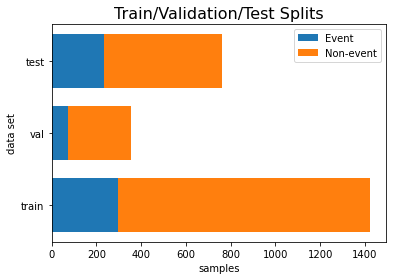

In [37]:
ind = [0, 1, 2]
names = ["train", "val", "test"]
width = 0.75
event_cnts = [np.unique(train_target,return_counts=True)[1][1],np.unique(val_target,return_counts=True)[1][1],np.unique(test_target,return_counts=True)[1][1]]
nonevent_cnts = [np.unique(train_target,return_counts=True)[1][0],np.unique(val_target,return_counts=True)[1][0],np.unique(test_target,return_counts=True)[1][0]]

p1 = plt.barh(ind, event_cnts, width)
p2 = plt.barh(ind, nonevent_cnts, width, left=event_cnts)

plt.yticks(ind, names)
plt.ylabel("data set")
plt.xlabel("samples")
plt.title("Train/Validation/Test Splits", fontsize=16)
plt.legend(["Event", "Non-event"])

## Step 2: Building Stacked LSTM

In [88]:
#Initialize the RNN
model = Sequential()

# Add LSTM layer and dropout regularization       #30,1     
model.add(LSTM(units = 30, return_sequences=True, input_shape = (pc_predictor.shape[1], 4)))
# Add Regularization 
model.add(Dropout(0.2))

model.add(LSTM(units = 20, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 10, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 5)) #default is tanh
model.add(Dropout(0.5))

# Add output layer 
model.add(Dense(units = 1,activation='sigmoid')) #default is linear activation ##,activation='sigmoid'

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 30)            4200      
                                                                 
 dropout_18 (Dropout)        (None, 60, 30)            0         
                                                                 
 lstm_19 (LSTM)              (None, 60, 20)            4080      
                                                                 
 dropout_19 (Dropout)        (None, 60, 20)            0         
                                                                 
 lstm_20 (LSTM)              (None, 60, 10)            1240      
                                                                 
 dropout_20 (Dropout)        (None, 60, 10)            0         
                                                                 
 lstm_21 (LSTM)              (None, 5)                

In [87]:
model

NameError: name 'model' is not defined

In [86]:
del model

## Step 3 : Compile, Train, Predict

In [89]:
# callbacks 
callbacks_path = '/home/mpyrina/Lorentz_workshop/Results/' #'/home/zwu/Lorentz_workshop/test/checkpoint_test'
metric = 'val_accuracy'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=callbacks_path,
        monitor='val_accuracy',
        save_best_only=True,
    )
]

In [91]:
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.metrics import brier_score_loss

# Compile the model  #model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']) #'binary_crossentropy'
model.compile(optimizer=Adam(lr=0.0001), loss = 'binary_crossentropy', metrics=['accuracy']) #metrics=[tf.keras.metrics.TruePositives()] , metrics=['accuracy']

#model.compile(optimizer=SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True),loss='binary_crossentropy') #,
#metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)])

#Create a class weight dictionary to help if the classes are unbalanced
def class_weight_creator(Y):
    class_dict = {}
    weights = np.max(np.sum(Y, axis=0)) / np.sum(Y, axis=0)
    for i in range( Y.shape[-1] ):
        class_dict[i] = weights[i]
    return class_dict
class_weight = class_weight_creator(train_predictor)

#from sklearn.utils import compute_class_weight
#classWeight = compute_class_weight('balanced', outputLabels, outputs) 
#classWeight = dict(enumerate(classWeight))

#Train model
#history=model.fit(train_predictor, train_target, epochs = 50, batch_size= 32)
history = model.fit(train_predictor, train_target, epochs=50, batch_size=32, 
                    callbacks=callbacks_list, validation_data=(val_predictor, val_target), 
                    verbose=2) #, class_weight=class_weight


Epoch 1/50


INFO:tensorflow:Assets written to: /home/mpyrina/Lorentz_workshop/Results/assets


INFO:tensorflow:Assets written to: /home/mpyrina/Lorentz_workshop/Results/assets


45/45 - 21s - loss: 0.5474 - accuracy: 0.7795 - val_loss: 0.6910 - val_accuracy: 0.4860 - 21s/epoch - 460ms/step
Epoch 2/50
45/45 - 2s - loss: 0.5347 - accuracy: 0.7879 - val_loss: 0.6906 - val_accuracy: 0.4775 - 2s/epoch - 55ms/step
Epoch 3/50
45/45 - 3s - loss: 0.5162 - accuracy: 0.8055 - val_loss: 0.6908 - val_accuracy: 0.4831 - 3s/epoch - 58ms/step
Epoch 4/50
45/45 - 3s - loss: 0.5058 - accuracy: 0.8153 - val_loss: 0.6913 - val_accuracy: 0.4579 - 3s/epoch - 63ms/step
Epoch 5/50
45/45 - 3s - loss: 0.4931 - accuracy: 0.8258 - val_loss: 0.6904 - val_accuracy: 0.4466 - 3s/epoch - 60ms/step
Epoch 6/50
45/45 - 3s - loss: 0.4790 - accuracy: 0.8357 - val_loss: 0.6932 - val_accuracy: 0.4438 - 3s/epoch - 63ms/step
Epoch 7/50
45/45 - 2s - loss: 0.4668 - accuracy: 0.8308 - val_loss: 0.6999 - val_accuracy: 0.4270 - 2s/epoch - 55ms/step
Epoch 8/50
45/45 - 2s - loss: 0.4601 - accuracy: 0.8399 - val_loss: 0.7055 - val_accuracy: 0.3989 - 2s/epoch - 55ms/step
Epoch 9/50
45/45 - 2s - loss: 0.4604 - a

In [29]:
to_categorical(train_target).shape

(1424, 2)

In [ ]:
to_categorical(val_target)[:,0]

In [92]:
#predict using test data (new data)
prediction = model.predict(test_predictor)
prediction

24/24 [==============================] - 2s 12ms/step


array([[0.11145891],
       [0.11184114],
       [0.11419347],
       [0.11896273],
       [0.12723838],
       [0.14100167],
       [0.16428368],
       [0.20494   ],
       [0.271041  ],
       [0.3621008 ],
       [0.45901647],
       [0.5405754 ],
       [0.597503  ],
       [0.632858  ],
       [0.65298706],
       [0.6640002 ],
       [0.66909677],
       [0.669991  ],
       [0.08806717],
       [0.08815677],
       [0.08825719],
       [0.08837161],
       [0.0884918 ],
       [0.08859585],
       [0.08867747],
       [0.08873853],
       [0.08879956],
       [0.08887254],
       [0.0889497 ],
       [0.08902506],
       [0.08912002],
       [0.08924554],
       [0.08941094],
       [0.08959784],
       [0.08978572],
       [0.08997134],
       [0.09017431],
       [0.0903945 ],
       [0.09062282],
       [0.09084828],
       [0.09107337],
       [0.09130593],
       [0.0915468 ],
       [0.09178576],
       [0.09202155],
       [0.09227911],
       [0.09257392],
       [0.092

In [62]:
#rescale back to original data
predicted_stock_price = scale.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[786.86456],
       [784.23456],
       [785.02167],
       [786.3982 ],
       [789.68915],
       [795.50525],
       [800.3019 ],
       [801.7698 ],
       [802.04016],
       [802.11865],
       [802.22284],
       [802.1705 ],
       [802.1069 ],
       [802.76807],
       [803.72076],
       [808.7118 ],
       [815.45715],
       [822.27356],
       [825.30054],
       [820.1695 ]], dtype=float32)

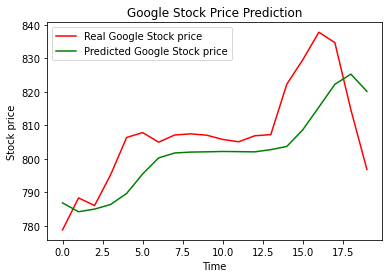

In [63]:
plt.plot(stock_price, color = 'red', label = 'Real Google Stock price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Google Stock price')
plt.title("Google Stock Price Prediction")
plt.xlabel('Time')
plt.ylabel('Stock price')
plt.legend()
plt.show()

In [65]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(stock_price, predicted_stock_price))

print(f"Mean square error : {rmse}")

Mean square error : 11.950925897261424


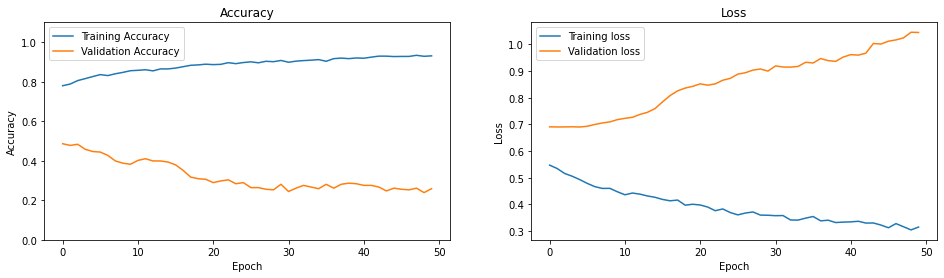

In [93]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0,1.1)
ax1.legend()

ax2.plot(train_loss, label='Training loss')
ax2.plot(val_loss, label='Validation loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

In [ ]:
import sklearn 
from sklearn.calibration import calibration_curve
import matplotlib.lines as line
import matplotlib.pyplot as plt 

x, y=calibration_curve(y_true, y_prob)

plt.plot(x,y)
ref = line.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration – Neptune.ai')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('Fraction of positive')
plt.legend()
plt.show()